URL not available: https://en.wikipedia.org/wiki/1916_Summer_Olympics_medal_table
URL not available: https://en.wikipedia.org/wiki/1940_Summer_Olympics_medal_table
URL not available: https://en.wikipedia.org/wiki/1944_Summer_Olympics_medal_table
URL not available: https://en.wikipedia.org/wiki/1916_Summer_Olympics_medal_table
URL not available: https://en.wikipedia.org/wiki/1940_Summer_Olympics_medal_table
URL not available: https://en.wikipedia.org/wiki/1944_Summer_Olympics_medal_table


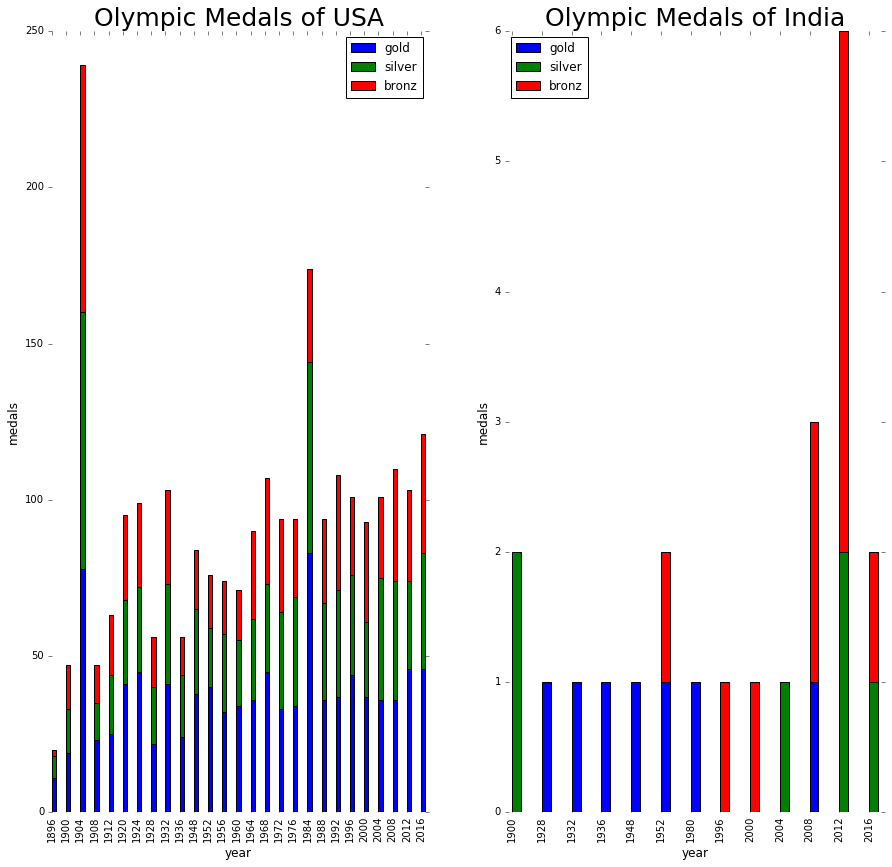

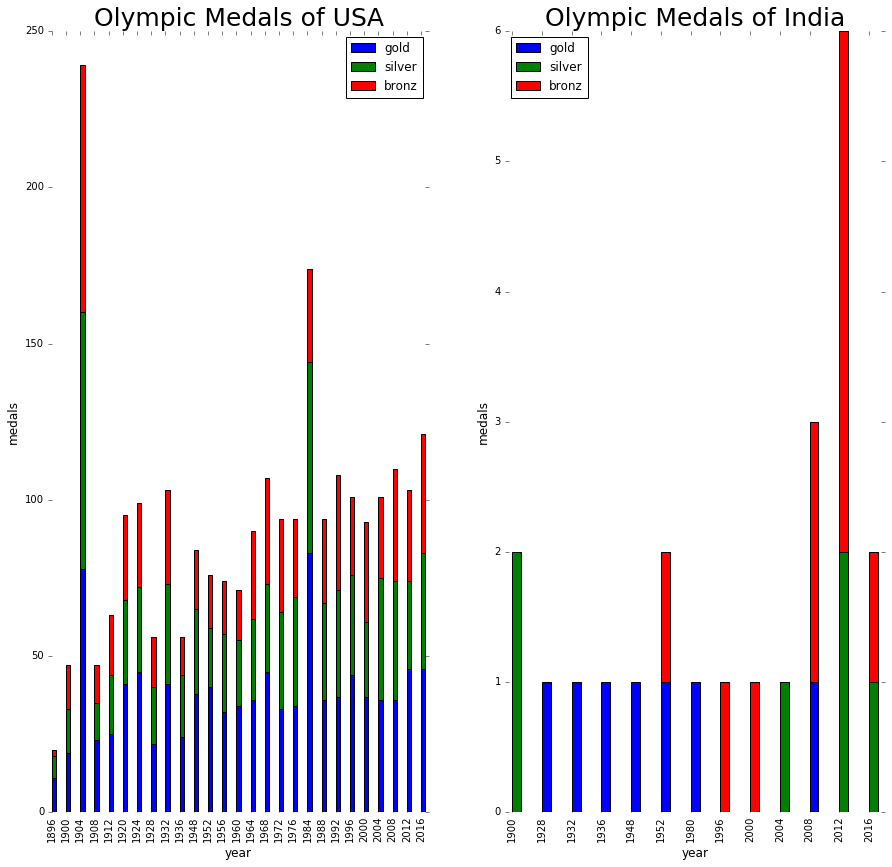

In [49]:
#%%writefile medal_analytics.py
#%load medal_analytics.py
%run medal_analytics.py
import os
import os.path
import urllib2

from bs4 import BeautifulSoup

import numpy as np

from pandas import Series, DataFrame
import pandas as pd

#%matplotlib inline
import matplotlib.pyplot as plt

import pdb

class SummerOlympics(object):

    def __getText(self, cell):
        #due to data observed like <num><superscript> or 65[1]
        t = cell.text.strip().split(" ")[0]
        return t.strip().split("[")[0]

    def __fetchUrlData(self, url):
        header = {'User-Agent': 'Mozilla/5.0'} #Needed to prevent 403 error on Wikipedia
        req = urllib2.Request(url, headers=header)
        try:
            page = urllib2.urlopen(req)
        except urllib2.HTTPError, e:
            print "URL not available: %s" % url
            return
        except urllib2.URLError, e:
            print (e, e.args)
            return
        return BeautifulSoup(page, "lxml") 

    def __scrapeOlympicMedalInfo(self, year, 
                                    dataDir="olympics_medal_data", 
                                    dataFilePostfix="-medals.csv"):
        if not os.path.exists(dataDir):
            os.makedirs(dataDir)
        df = None
        filePath = os.path.join(os.getcwd(), dataDir, "%s-%s" % (year, dataFilePostfix))
        if not os.path.exists(filePath):
            wiki = "https://en.wikipedia.org/wiki/%s_Summer_Olympics_medal_table" % year
            soup = self.__fetchUrlData(wiki)
            if soup is None:
                return
            table = soup.findAll("table", { "class" : [ "wikitable sortable plainrowheaders", 
                                                        "wikitable"]})
            if not table:
                print "Could not find table for year %s" % year
                return
            #1928 has 2 tables
            table = table[0]
            rank = 0
            country = None
            gold = 0
            silver = 0
            bronz = 0
            total = 0
            prevRank = 0

            data = []
            for row in table.findAll("tr")[1:-1]:
                try:
                    ths = row.findAll("th")
                    if ths:
                        country = row.findAll("th")[0].img['title']

                    tds = row.findAll("td")
                    if len(tds) == 6:
                        rank = self.__getText(tds[0])
                        if hasattr(tds[1], 'img'):
                            country = tds[1].img['title']
                        gold = self.__getText(tds[2])
                        silver = self.__getText(tds[3])
                        bronz = self.__getText(tds[4])
                        total = self.__getText(tds[5])
                    elif len(tds) == 5:
                        #mostly older pages have 5 tds and country in tds
                        #1900 has mexico and sweden rank applicable to 2 rows
                        prevRank = rank
                        try:
                            rank = self.__getText(tds[0])
                        except Exception, e:
                            print e
                            #use previous row's rank
                        if not rank.isnumeric():
                            country = rank
                            rank = prevRank
                        else:
                            if not country:
                                country = rank #getText(tds[0])
                        gold = self.__getText(tds[1])
                        silver = self.__getText(tds[2])
                        bronz = self.__getText(tds[3])
                        total = self.__getText(tds[4])
                    elif len(tds) == 4:
                        gold = self.__getText(tds[0])
                        silver = self.__getText(tds[1])
                        bronz = self.__getText(tds[2])
                        total = self.__getText(tds[3])
                    else:
                        raise Exception("Invalid Data")

                except IndexError, e:
                    print e

                col = (year, rank, country, gold, silver, bronz, total)
                data.append(col)

            df = pd.DataFrame(data, columns=['year', 'rank', 'country', 'gold', 'silver', 'bronz', 'total'])
            df.to_csv(filePath, header=True, index=False, encoding='utf-8')
        else:
            df = pd.read_csv(filePath)

        # Normalize data types
        df[['rank', 'gold', 'silver', 'bronz', 'total']] = df[['rank', 'gold', 'silver', 'bronz', 'total']].astype(int)

        df = df.set_index(['year', 'country'])
        return df

    def populateSummerOlympicMedalsForAllYears(self):
        #https://en.wikipedia.org/wiki/Olympic_medal_table
        modernOlympicsStartYear=1896
        dff = None
        for year in xrange(modernOlympicsStartYear, 2020, 4):
            df = self.__scrapeOlympicMedalInfo(year)
            if df is None:
                continue
            #print df
            if dff is None:
                dff = df
            else:
                dff = dff.append(df)
        return dff

    def __scrapeSummerOlympicGamesInfo(self,
                                    dataDir="olympics_medal_data", 
                                    dataFilePostfix="games.csv"):
        if not os.path.exists(dataDir):
            os.makedirs(dataDir)
        df = None
        filePath = os.path.join(os.getcwd(), dataDir, "%s" % (dataFilePostfix))
        if not os.path.exists(filePath):
            wiki = "https://en.wikipedia.org/wiki/Summer_Olympic_Games"
            soup = self.__fetchUrlData(wiki)
            table = soup.findAll("table", { "class" : [ "wikitable sortable plainrowheaders", 
                                                        "wikitable"]})
            if not table:
                print "Could not tables in url %s" % wiki
                return
            table = table[0]

        return df

    def populateSummerOlympicGamesDetails(self):
        df = self.__scrapeSummerOlympicGamesInfo()
        return df

    def plotIndiaUSATallyForAllYears(self, dfMedals):
        dfIndiaByYears = dfMedals.xs('India', level='country')
        dfUSAByYears = dfMedals.xs('United States', level='country')

        barWidth = 0.3
        fig = plt.figure(figsize=(15, 14)) # Create matplotlib figure

        #Plot first graph
        ax = fig.add_subplot(121) # Create matplotlib axes
        ax.spines["top"].set_visible(False)  
        ax.spines["bottom"].set_visible(False)  
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(False)  
        
        p = dfUSAByYears[['gold', 'silver', 'bronz']].plot(ax=ax, width=barWidth, position=0, kind='bar', stacked=True)
        p.set_title('Olympic Medals of USA', fontsize=25)
        p.set_xlabel('year', fontsize=12)
        p.set_ylabel('medals', fontsize=12)

        #Plot end graph graph
        ax = fig.add_subplot(122) # Create matplotlib axes 
        ax.spines["top"].set_visible(False)  
        ax.spines["bottom"].set_visible(False)  
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(False)  
        
        q = dfIndiaByYears[['gold', 'silver', 'bronz']].plot(ax=ax, width=barWidth, position=0, kind='bar', stacked=True)
        q.set_title('Olympic Medals of India', fontsize=25)
        q.set_xlabel('year', fontsize=12)
        q.set_ylabel('medals', fontsize=12)
        
        return

        #Plot third graph
        ax = fig.add_subplot(313) # Create matplotlib axes
        ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

        ax = plt.subplot(313)  
        ax.spines["top"].set_visible(False)  
        ax.spines["bottom"].set_visible(False)  
        ax.spines["right"].set_visible(False)  
        ax.spines["left"].set_visible(False)  

        ax2.spines["top"].set_visible(False)  
        ax2.spines["bottom"].set_visible(False)  
        ax2.spines["right"].set_visible(False)  
        ax2.spines["left"].set_visible(False) 

        p = dfUSAByYears[['gold', 'silver', 'bronz']].plot(ax=ax, width=barWidth, position=0, kind='bar', stacked=True)
        q = dfIndiaByYears[['gold', 'silver', 'bronz']].plot(ax=ax2, width=barWidth, position=1, kind='bar', stacked=True)

if __name__ == "__main__":
    so = SummerOlympics()
    dfMedals = so.populateSummerOlympicMedalsForAllYears()
    if dfMedals is None:
        exit(1)

    so.plotIndiaUSATallyForAllYears(dfMedals)

    dfGames = so.populateSummerOlympicGamesDetails()
    if dfMedals is None:
        exit(1)